In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import statistics

# Step 1

Mean profit over 1000 simulations: $41780.30
Std dev of profit: $711.16


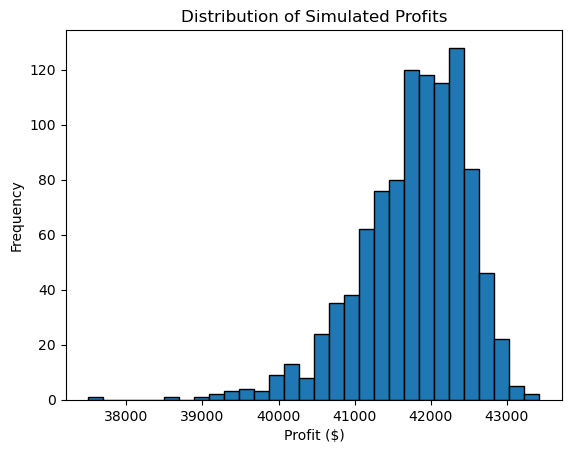

In [ ]:
# Number of days to sell
T = 365

coach_capacity = 100
fc_capacity = 20
coach_overbook = coach_capacity + 5  # 105 total possible coach tickets sold
fc_max = fc_capacity # 20 total possible first-class tickets sold

# Discounting: 17% per year => daily discount factor
annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

# Probabilities of selling exactly 1 ticket in each class (independent),
# depending on chosen price. Base (not sold out) probabilities:
# coach: 300 => 65%, 350 => 30%
# first-class: 425 => 8%, 500 => 4%

def coach_prob(price_coach, fc_sold_out, coach_full):
    if coach_full:
        return 0.0  # can't sell any more coach seats

    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30

    # If first class is sold out, add +3%
    if fc_sold_out:
        base_p += 0.03

    # Cap at 1.0 just in case the +3% pushes above 1 (rare, but safe)
    return min(base_p, 1.0)

def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0  # can't sell FC if coach is at overbook limit
    if fc_sold >= fc_max:
        return 0.0  # FC is sold out
    if price_fc == 425:
        return 0.08
    else:
        return 0.04

# Overbooking cost parameters:
cost_bump_up = 50   # cost to bump coach -> first-class
cost_bump_off= 425  # cost to bump coach passenger off-plane
prob_show_coach = 0.95
prob_show_fc    = 0.97

# State: (coach_sold, fc_sold, t)
#   coach_sold in [0 .. 105]
#   fc_sold in [0 .. 20]
#   t in [0 .. 365], where t=365 is departure day (no more sales, only cost).
#
# Action: pick from 4 combos => (CoachPrice, FCPrice):
#    0 => (300, 425)
#    1 => (300, 500)
#    2 => (350, 425)
#    3 => (350, 500)

coach_price_list = [300, 300, 350, 350]
fc_price_list  = [425, 500, 425, 500]

# For storing DP results
V = np.zeros((coach_overbook+1, fc_max+1, T+1))  # value function
U = np.zeros((coach_overbook+1, fc_max+1, T+1))  # best action index [0..3]

# On departure day t=365, there's no revenue. Only incur the expected cost
# from overbooking. 

def expected_overbook_cost(x_coach, x_fc):
    # x_coach in [0..105], x_fc in [0..20]
    # Let c ~ Binomial(x_coach, 0.95), f ~ Binomial(x_fc, 0.97)
    # Seat f in first-class (capacity=20), that uses up min(f,20) seats,
    # leftover first-class seats: leftover_fc = max(0, 20 - f)
    # Seat min(c,100) in coach, but can bump up to leftover_fc from coach if c>100
    # cost = 50 * (# bumped to FC) + 425 * (# turned away).
    # Sum over pmf(c,f).
    cost = 0.0
    for c in range(x_coach+1):
        pc = stats.binom.pmf(c, x_coach, prob_show_coach)
        for f in range(x_fc+1):
            pf = stats.binom.pmf(f, x_fc, prob_show_fc)
            p_joint = pc * pf
            
            leftover_fc = max(0, fc_capacity - f)  # seats in first class not used by FC tickets
            if c <= coach_capacity:
                # No one is forced off-plane from coach
                # Possibly some leftover seats in first class, but no forced bumps if c<=100
                bump_to_fc  = 0  # Only upgrade if c>100
                bump_off    = 0
            else:
                # c > 100 => need c-100 extra seats
                # Can move min(leftover_fc, c-100) to first class
                to_bump = c - coach_capacity  # # needing a seat beyond coach capacity
                bump_to_fc = min(leftover_fc, to_bump)
                bump_off   = to_bump - bump_to_fc
            
            # cost for this scenario
            scenario_cost = cost_bump_up * bump_to_fc + cost_bump_off * bump_off
            cost += p_joint * scenario_cost
    return cost

# Fill the terminal day (t=365)
for x_c in range(coach_overbook+1):
    for x_f in range(fc_max+1):
        cost_here = expected_overbook_cost(x_c, x_f)
        V[x_c, x_f, T] = -cost_here  # negative cost
        U[x_c, x_f, T] = 0          # no "action" needed at departure


for t in reversed(range(T)):
    for x_c in range(coach_overbook+1):
        for x_f in range(fc_max+1):
            # Compute the expected discounted value for each of the 4 possible actions.
            # Then pick the best (max).
            best_value = -1e15
            best_action= 0
            
            for action_idx in range(4):
                pc_choice = coach_price_list[action_idx]
                fc_choice = fc_price_list[action_idx]
                
                # Calculate *effective* prob(1 coach sale) and prob(1 fc sale),
                # given the special sold-out rules:
                fc_sold_out   = (x_f >= fc_max)
                coach_at_limit= (x_c >= coach_overbook)
                
                prob_c = coach_prob(pc_choice, fc_sold_out, coach_at_limit)
                prob_f = fc_prob(fc_choice, coach_at_limit, x_f)
                
                # Because the problem states demand for coach & first class are independent,
                # have 4 possible events: (0,0), (1,0), (0,1), (1,1).
                #   E[Revenue] = 0*(1-pc)(1-pf) + pc_choice*(1 seat) * etc. 
                
                # Probability of coach sale = prob_c
                # Probability of FC sale = prob_f
                # So:
                #   P(0 coach, 0 fc) = (1-prob_c)*(1-prob_f)
                #   P(1 coach, 0 fc) = prob_c*(1-prob_f)
                #   P(0 coach, 1 fc) = (1-prob_c)*prob_f
                #   P(1 coach, 1 fc) = prob_c*prob_f
                
                # Immediate revenue from each outcome
                #   (0,0): 0
                #   (1,0): pc_choice
                #   (0,1): fc_choice
                #   (1,1): pc_choice + fc_choice
                
                # Next state transitions:
                #   (1,0) => (x_c+1, x_f)
                #   (0,1) => (x_c, x_f+1)
                #   (1,1) => (x_c+1, x_f+1)
                
                # Do NOT exceed x_c+1 > overbook or x_f+1 > 20, 
                # This is handled by prob_c=0 or prob_f=0 if we can't sell more?
                
                p00 = (1 - prob_c)*(1 - prob_f)
                p10 = prob_c*(1 - prob_f)
                p01 = (1 - prob_c)*prob_f
                p11 = prob_c*prob_f
                
                # immediate revenue expectation
                immediate_rev = (p10*pc_choice 
                                 + p01*fc_choice 
                                 + p11*(pc_choice+fc_choice))
                
                # next-state value
                vc00 = V[x_c, x_f, t+1]
                vc10 = V[x_c+1, x_f, t+1] if x_c < coach_overbook else V[x_c, x_f, t+1]
                vc01 = V[x_c, x_f+1, t+1] if x_f < fc_max else V[x_c, x_f, t+1]
                vc11 = V[x_c+1, x_f+1, t+1] if (x_c<coach_overbook and x_f<fc_max) else V[x_c, x_f, t+1]
                
                exp_next_val = (p00 * vc00 +
                                p10 * vc10 +
                                p01 * vc01 +
                                p11 * vc11)
                
                # total expected value from this action
                # immediate revenue + discounted next-state value
                total_val = immediate_rev + delta * exp_next_val
                
                # If it's better than our current best, update
                if total_val > best_value:
                    best_value  = total_val
                    best_action = action_idx
            
            # Store the best action & best value
            V[x_c, x_f, t] = best_value
            U[x_c, x_f, t] = best_action

# Simulate day by day from t=0..364 using the policy. On day=365, impose
# the overbooking cost. Do 1000 simulation runs to see the distribution.

N = 1000  # number of Monte Carlo simulations
final_profits = np.zeros(N)

for sim in range(N):
    x_c = 0  # coach sold so far
    x_f = 0  # fc sold so far
    sim_revenue = 0.0
    
    for day in range(T):
        action_idx = int(U[x_c, x_f, day])
        pc_choice  = coach_price_list[action_idx]
        fc_choice  = fc_price_list[action_idx]

        # compute sale probabilities for this day
        fc_sold_out = (x_f >= fc_max)
        coach_full  = (x_c >= coach_overbook)
        
        prob_c = coach_prob(pc_choice, fc_sold_out, coach_full)
        prob_f = fc_prob(fc_choice, coach_full, x_f)

        # realize if a coach sale happens
        c_sale = (np.random.rand() < prob_c)
        # realize if a fc sale happens
        f_sale = (np.random.rand() < prob_f)
        
        # immediate revenue this day
        day_revenue = 0.0
        if c_sale:
            day_revenue += pc_choice
            x_c += 1  # increment sold coach
        if f_sale:
            day_revenue += fc_choice
            x_f += 1  # increment sold fc
        
        # discount the daily revenue
        sim_revenue += day_revenue * (delta**day)
    
    # End of selling phase, day=365 => impose overbooking cost
    # Generate actual show-ups
    c_show = np.random.binomial(x_c, prob_show_coach)
    f_show = np.random.binomial(x_f, prob_show_fc)
    
    leftover_fc = max(0, fc_capacity - f_show)
    to_bump = max(0, c_show - coach_capacity)
    bump_to_fc = min(leftover_fc, to_bump)
    bump_off = max(0, to_bump - bump_to_fc)
    over_cost = cost_bump_up * bump_to_fc + cost_bump_off * bump_off
    
    # Day=365 discount:
    sim_revenue -= over_cost * (delta**T)

    final_profits[sim] = sim_revenue

# Analyze results
print(f"Mean profit over {N} simulations: ${final_profits.mean():0.2f}")
print(f"Std dev of profit: ${final_profits.std():0.2f}")
plt.figure()
plt.hist(final_profits, bins=30, edgecolor='k')
plt.title("Distribution of Simulated Profits")
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Number of days to sell
T = 365

coach_capacity = 100
fc_capacity = 20

# Overbooking: 100 physical seats in coach + 5 extra
coach_overbook = coach_capacity + 5 # i.e., up to 105 sold
fc_max = fc_capacity # 20 total possible first-class tickets sold

# Discounting: 17% per year => daily discount factor
annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

# Base demand probabilities
#   Coach: if price=300 => 65%, else (350) => 30%
#   First-class: if price=425 => 8%, else (500) => 4%
#   If first-class is sold out => coach demand +3%
#   If coach is at overbook limit => first-class can't sell
def coach_prob(price_coach, fc_sold_out, coach_full):
    if coach_full:
        return 0.0
    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30
    if fc_sold_out:
        base_p += 0.03
    return min(base_p, 1.0)

def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0
    if fc_sold >= fc_max:
        return 0.0
    if price_fc == 425:
        return 0.08
    else:
        return 0.04

# Overbooking costs
cost_bump_up = 50   # cost to bump coach -> first-class
cost_bump_off= 425  # cost to bump coach passenger off-plane
prob_show_coach = 0.95
prob_show_fc = 0.97

# Action space: 4 combos => (CoachPrice, FCPrice)
coach_price_list = [300, 300, 350, 350]
fc_price_list = [425, 500, 425, 500]

# DP Arrays
# V[c, f, t]: expected discounted profit from day t onward with c coach tickets sold, f first-class sold
V = np.zeros((coach_overbook+1, fc_max+1, T+1))
U = np.zeros((coach_overbook+1, fc_max+1, T+1))

def expected_overbook_cost(x_coach, x_fc):
    cost = 0.0
    for c in range(x_coach+1):
        pc = stats.binom.pmf(c, x_coach, prob_show_coach)
        for f in range(x_fc+1):
            pf = stats.binom.pmf(f, x_fc, prob_show_fc)
            p_joint = pc * pf
            
            leftover_fc = max(0, fc_capacity - f)
            if c <= coach_capacity:
                bump_to_fc = 0
                bump_off = 0
            else:
                to_bump = c - coach_capacity
                bump_to_fc = min(leftover_fc, to_bump)
                bump_off = to_bump - bump_to_fc
            scenario_cost = cost_bump_up*bump_to_fc + cost_bump_off*bump_off
            cost += p_joint * scenario_cost
    return cost

# Terminal condition (t=365): no more ticket revenue, only overbooking cost
for c_sold in range(coach_overbook+1):
    for f_sold in range(fc_max+1):
        cost_here = expected_overbook_cost(c_sold, f_sold)
        V[c_sold, f_sold, T] = -cost_here
        U[c_sold, f_sold, T] = 0   # no action at departure

# Backward recursion: t=364 down to 0
for t in reversed(range(T)):
    for c_sold in range(coach_overbook+1):
        for f_sold in range(fc_max+1):
            best_val = -1e15
            #best_val = 0
            best_act = 0
            fc_sold_out  = (f_sold >= fc_max)
            coach_at_limit = (c_sold >= coach_overbook)
            
            # Evaluate each of the 4 price combos
            for action_idx in range(4):
                pc_price = coach_price_list[action_idx]
                fc_price = fc_price_list[action_idx]
                
                p_c = coach_prob(pc_price, fc_sold_out, coach_at_limit)
                p_f = fc_prob(fc_price, coach_at_limit, f_sold)
                
                # Probabilities of outcomes (0,0), (1,0), (0,1), (1,1)
                p00 = (1 - p_c)*(1 - p_f)
                p10 = p_c*(1 - p_f)
                p01 = (1 - p_c)*p_f
                p11 = p_c*p_f
                
                # Immediate expected revenue
                immediate_rev = (p10*pc_price + p01*fc_price + p11*(pc_price+fc_price))
                
                # Next-state transitions
                vc00 = V[c_sold, f_sold, t+1]
                vc10 = V[min(c_sold+1, coach_overbook), f_sold, t+1]
                vc01 = V[c_sold, min(f_sold+1, fc_max), t+1]
                vc11 = V[min(c_sold+1, coach_overbook), min(f_sold+1, fc_max), t+1]
                
                exp_val_next = (p00*vc00 + p10*vc10 + p01*vc01 + p11*vc11)
                total_val = immediate_rev + delta*exp_val_next
                
                if total_val > best_val:
                    best_val  = total_val
                    best_act  = action_idx
            
            V[c_sold, f_sold, t] = best_val
            U[c_sold, f_sold, t] = best_act

optimal_profit = V[0, 0, 0]
print(f"Expected discounted profit (coach +5 oversell) = ${optimal_profit:0.2f}")

Expected discounted profit (coach +5 oversell) = $41792.40


# Step 2

In [ ]:
T = 365
coach_capacity = 100
fc_capacity = 20
fc_max = fc_capacity # 20 total possible first-class tickets sold

# Discounting: 17% per year => daily discount factor
annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

# Probabilities for coach demand given price
# base: 300 => 65%, 350 => 30%
# If first-class is sold out => +3%
def coach_prob(price_coach, fc_sold_out, coach_full):
    if coach_full:
        return 0.0  # can't sell any more coach seats

    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30

    if fc_sold_out:
        base_p += 0.03

    return min(base_p, 1.0)

# Probabilities for first-class demand given price
# base: 425 => 8%, 500 => 4%
# If coach is at limit => 0 (from problem statement)
def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0  
    if fc_sold >= fc_max:
        return 0.0  
    if price_fc == 425:
        return 0.08
    else:
        return 0.04

# Overbooking cost parameters:
cost_bump_up = 50    # cost to bump coach -> first-class
cost_bump_off = 425   # cost to bump coach passenger off-plane
prob_show_coach = 0.95
prob_show_fc = 0.97

# Pricing actions: (CoachPrice, FCPrice)
coach_price_list = [300, 300, 350, 350]
fc_price_list = [425, 500, 425, 500]

def run_overbooking_dp(extra_coach_seats, N=1000):
    # Build state space dims
    max_coach_sold = coach_capacity + extra_coach_seats  # e.g. 100 + 6 = 106
    fc_max_sold = fc_max                              # e.g. 20
    
    # Initialize DP arrays
    V = np.zeros((max_coach_sold+1, fc_max_sold+1, T+1))  
    U = np.zeros((max_coach_sold+1, fc_max_sold+1, T+1))
    
    # Terminal day overbook cost
    def expected_overbook_cost(x_coach, x_fc):
        cost = 0.0
        for c in range(x_coach+1):
            pc = stats.binom.pmf(c, x_coach, prob_show_coach)
            for f in range(x_fc+1):
                pf = stats.binom.pmf(f, x_fc, prob_show_fc)
                p_joint = pc * pf
                
                leftover_fc = max(0, fc_capacity - f)
                if c <= coach_capacity:
                    bump_to_fc = 0
                    bump_off = 0
                else:
                    to_bump = c - coach_capacity
                    bump_to_fc= min(leftover_fc, to_bump)
                    bump_off = to_bump - bump_to_fc
                scenario_cost = cost_bump_up*bump_to_fc + cost_bump_off*bump_off
                cost += p_joint*scenario_cost
        return cost

    for x_c in range(max_coach_sold+1):
        for x_f in range(fc_max_sold+1):
            cost_here = expected_overbook_cost(x_c, x_f)
            V[x_c, x_f, T] = -cost_here
            U[x_c, x_f, T] = 0   # no action at departure

    # Backward recursion
    for tday in reversed(range(T)):
        for x_c in range(max_coach_sold+1):
            for x_f in range(fc_max_sold+1):
                best_value  = -1e15
                best_action = 0
                for action_idx in range(4):
                    pc_choice = coach_price_list[action_idx]
                    fc_choice = fc_price_list[action_idx]
                    
                    fc_sold_out = (x_f >= fc_max_sold)
                    coach_full = (x_c >= max_coach_sold)
                    
                    p_c = coach_prob(pc_choice, fc_sold_out, coach_full)
                    p_f = fc_prob(fc_choice, coach_full, x_f)
                    
                    # 4 outcomes for (coach sale, fc sale)
                    p00 = (1 - p_c)*(1 - p_f)
                    p10 = p_c*(1 - p_f)
                    p01 = (1 - p_c)*p_f
                    p11 = p_c*p_f
                    
                    rev_immediate = (p10*pc_choice +
                                     p01*fc_choice +
                                     p11*(pc_choice+fc_choice))
                    
                    vc00 = V[x_c, x_f, tday+1]
                    vc10 = V[x_c+1, x_f, tday+1] if x_c < max_coach_sold else V[x_c, x_f, tday+1]
                    vc01 = V[x_c,x_f+1, tday+1] if x_f < fc_max_sold else V[x_c, x_f, tday+1]
                    vc11 = V[x_c+1, x_f+1, tday+1] if (x_c<max_coach_sold and x_f<fc_max_sold) else V[x_c, x_f, tday+1]
                    
                    exp_val_next = p00*vc00 + p10*vc10 + p01*vc01 + p11*vc11
                    total_val = rev_immediate + delta*exp_val_next
                    
                    if total_val > best_value:
                        best_value  = total_val
                        best_action = action_idx
                
                V[x_c, x_f, tday] = best_value
                U[x_c, x_f, tday] = best_action
    
    # Forward simulation
    final_profits = np.zeros(N)
    for sim_i in range(N):
        c_sold = 0
        f_sold = 0
        sim_revenue = 0.0
        
        for day in range(T):
            action_idx = int(U[c_sold, f_sold, day])
            pc_choice  = coach_price_list[action_idx]
            fc_choice  = fc_price_list[action_idx]
            
            fc_sold_out = (f_sold >= fc_max_sold)
            coach_full  = (c_sold >= max_coach_sold)
            
            p_c = coach_prob(pc_choice, fc_sold_out, coach_full)
            p_f = fc_prob(fc_choice, coach_full, f_sold)
            
            # Realize sales
            c_sale = (np.random.rand() < p_c)
            f_sale = (np.random.rand() < p_f)
            
            daily_rev = 0.0
            if c_sale:
                daily_rev += pc_choice
                c_sold += 1
            if f_sale:
                daily_rev += fc_choice
                f_sold += 1
            
            # discount daily revenue
            sim_revenue += daily_rev * (delta**day)
        
        # day=365 => actual show-ups
        c_show = np.random.binomial(c_sold, prob_show_coach)
        f_show = np.random.binomial(f_sold, prob_show_fc)
        
        leftover_fc = max(0, fc_capacity - f_show)
        to_bump = max(0, c_show - coach_capacity)
        bump_to_fc = min(leftover_fc, to_bump)
        bump_off   = max(0, to_bump - bump_to_fc)
        over_cost  = cost_bump_up*bump_to_fc + cost_bump_off*bump_off
        
        # discount the cost
        sim_revenue -= over_cost * (delta**T)
        
        final_profits[sim_i] = sim_revenue
    
    mean_profit = final_profits.mean()
    return mean_profit, final_profits

overbook_range = range(6, 16)  # 6..15

best_overbook = None
best_mean = -1e15
all_results = []

for ob in overbook_range:
    mp, _ = run_overbooking_dp(ob, N=1000)  # 1000 simulations per run
    all_results.append((ob, mp))
    if mp > best_mean:
        best_mean = mp
        best_overbook = ob
    print(f"Overbook +{ob} => Mean Profit = ${mp:0.2f}")

print(f"BEST overbooking limit was +{best_overbook}, "
      f"with mean simulated profit of ${best_mean:0.2f}.")

Overbook +6 => Mean Profit = $41931.45
Overbook +7 => Mean Profit = $42041.28
Overbook +8 => Mean Profit = $42124.26
Overbook +9 => Mean Profit = $42070.95
Overbook +10 => Mean Profit = $42124.05
Overbook +11 => Mean Profit = $42062.92
Overbook +12 => Mean Profit = $42067.12
Overbook +13 => Mean Profit = $42097.71
Overbook +14 => Mean Profit = $42105.11
Overbook +15 => Mean Profit = $42076.73
BEST overbooking limit was +8, with mean simulated profit of $42124.26.


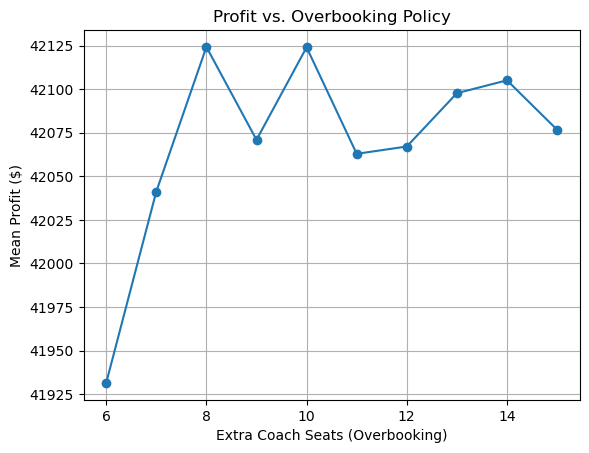

In [6]:
overs, profits = zip(*all_results)
plt.figure()
plt.plot(overs, profits, marker='o')
plt.xlabel('Extra Coach Seats (Overbooking)')
plt.ylabel('Mean Profit ($)')
plt.title('Profit vs. Overbooking Policy')
plt.grid(True)
plt.show()

In [ ]:
T = 365
coach_capacity = 100
fc_capacity = 20
fc_max = fc_capacity

annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

cost_bump_up = 50
cost_bump_off = 425
prob_show_coach = 0.95
prob_show_fc = 0.97

# Base probabilities
def coach_prob(price_coach, fc_sold_out, coach_full):
    if coach_full:
        return 0.0
    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30
    if fc_sold_out:
        base_p += 0.03
    return min(base_p, 1.0)

def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0
    if fc_sold >= fc_max:
        return 0.0
    if price_fc == 425:
        return 0.08
    else:
        return 0.04

coach_price_list = [300, 300, 350, 350]
fc_price_list = [425, 500, 425, 500]

def run_overbooking_dp(extra_coach_seats):
    max_coach_sold = coach_capacity + extra_coach_seats
    fc_max_sold = fc_max

    # DP arrays
    V = np.zeros((max_coach_sold+1, fc_max_sold+1, T+1))
    U = np.zeros((max_coach_sold+1, fc_max_sold+1, T+1))

    def expected_overbook_cost(x_coach, x_fc):
        cost = 0.0
        for c in range(x_coach+1):
            pc = stats.binom.pmf(c, x_coach, prob_show_coach)
            for f in range(x_fc+1):
                pf = stats.binom.pmf(f, x_fc, prob_show_fc)
                p_joint = pc * pf

                leftover_fc = max(0, fc_capacity - f)
                if c <= coach_capacity:
                    bump_to_fc = 0
                    bump_off = 0
                else:
                    to_bump = c - coach_capacity
                    bump_to_fc = min(leftover_fc, to_bump)
                    bump_off = to_bump - bump_to_fc
                cost += p_joint * (cost_bump_up*bump_to_fc + cost_bump_off*bump_off)
        return cost

    # Terminal condition
    for x_c in range(max_coach_sold+1):
        for x_f in range(fc_max_sold+1):
            over_cost = expected_overbook_cost(x_c, x_f)
            V[x_c, x_f, T] = -over_cost
            U[x_c, x_f, T] = 0

    # Backward DP
    for tday in reversed(range(T)):
        for x_c in range(max_coach_sold+1):
            for x_f in range(fc_max_sold+1):
                best_val = -1e15
                best_act= 0
                fc_sold_out = (x_f >= fc_max_sold)
                coach_full = (x_c >= max_coach_sold)

                for action_idx in range(4):
                    pc_choice = coach_price_list[action_idx]
                    fc_choice = fc_price_list[action_idx]

                    p_c = coach_prob(pc_choice, fc_sold_out, coach_full)
                    p_f = fc_prob(fc_choice, coach_full, x_f)

                    p00 = (1 - p_c)*(1 - p_f)
                    p10 = p_c*(1 - p_f)
                    p01 = (1 - p_c)*p_f
                    p11 = p_c*p_f

                    rev_immediate = p10*pc_choice + p01*fc_choice + p11*(pc_choice+fc_choice)

                    vc00 = V[x_c, x_f, tday+1]
                    vc10 = V[min(x_c+1, max_coach_sold), x_f, tday+1]
                    vc01 = V[x_c, min(x_f+1, fc_max_sold), tday+1]
                    vc11 = V[min(x_c+1, max_coach_sold), min(x_f+1, fc_max_sold), tday+1]

                    exp_next_val = p00*vc00 + p10*vc10 + p01*vc01 + p11*vc11
                    total_val = rev_immediate + delta*exp_next_val

                    if total_val > best_val:
                        best_val = total_val
                        best_act = action_idx

                V[x_c, x_f, tday] = best_val
                U[x_c, x_f, tday] = best_act

    # The expected discounted profit from the initial state:
    return V[0, 0, 0]

overbook_range = range(6, 16)
best_overbook = None
best_mean = -1e15
results = []

for ob in overbook_range:
    edp = run_overbooking_dp(ob)
    results.append((ob, edp))
    print(f"Overbook +{ob} => Theoretical EDP = ${edp:0.2f}")
    if edp > best_mean:
        best_mean = edp
        best_overbook = ob

print(f"BEST overbooking limit was +{best_overbook}, with EDP = ${best_mean:0.2f}")

Overbook +6 => Theoretical EDP = $41930.97
Overbook +7 => Theoretical EDP = $42017.84
Overbook +8 => Theoretical EDP = $42065.71
Overbook +9 => Theoretical EDP = $42087.94
Overbook +10 => Theoretical EDP = $42094.43
Overbook +11 => Theoretical EDP = $42091.94
Overbook +12 => Theoretical EDP = $42084.78
Overbook +13 => Theoretical EDP = $42075.60
Overbook +14 => Theoretical EDP = $42065.93
Overbook +15 => Theoretical EDP = $42056.61
BEST overbooking limit was +10, with EDP = $42094.43


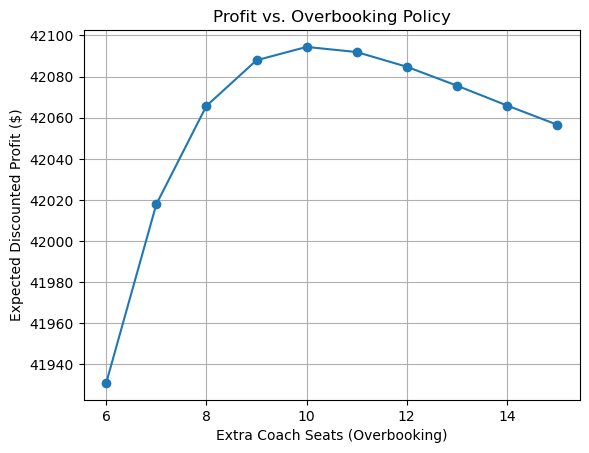

In [6]:
overs, profits = zip(*results)
plt.plot(overs, profits, marker='o')
plt.xlabel('Extra Coach Seats (Overbooking)')
plt.ylabel('Expected Discounted Profit ($)')
plt.title('Profit vs. Overbooking Policy')
plt.grid(True)
plt.show()

# Step 3

Mean Profit with 'No-Sale' Coach Option (cap=120): $42157.35
Std Dev of Profit: $946.70


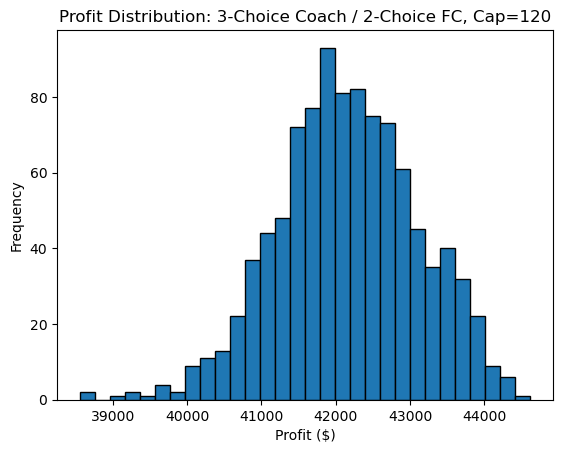

In [ ]:
T = 365
coach_physical = 100
coach_max_sold = 120  
fc_capacity = 20

# Discount rate = 17% per year => daily discount
annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

# Probability that each sold ticket shows up
prob_show_coach = 0.95
prob_show_fc = 0.97

# Overbooking / bumping costs
cost_bump_up  = 50
cost_bump_off = 425

# coach_price=0 means "no sale" (force zero demand).
action_space = [
    (0, 425), # 0 => no-coach, fc=425
    (0, 500), # 1 => no-coach, fc=500
    (300, 425), # 2 => coach $300, fc=425
    (300, 500), # 3 => coach $300, fc=500
    (350, 425), # 4 => coach $350, fc=425
    (350, 500)  # 5 => coach $350, fc=500
]

def coach_prob(price_coach, fc_sold_out, coach_full):
    if price_coach == 0:
        return 0.0  # forced no sale
    if coach_full:
        return 0.0
    
    # base probability
    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30
    
    if fc_sold_out:
        base_p = min(base_p + 0.03, 1.0)
    
    return base_p

def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0
    if fc_sold >= 20:
        return 0.0
    if price_fc == 425:
        return 0.08
    else:
        return 0.04

def expected_overbook_cost(x_coach, x_fc):
    cost = 0.0
    for c in range(x_coach+1):
        p_c = stats.binom.pmf(c, x_coach, prob_show_coach)
        for f in range(x_fc+1):
            p_f = stats.binom.pmf(f, x_fc, prob_show_fc)
            p_joint = p_c * p_f

            leftover_fc = max(0, fc_capacity - f)
            if c <= coach_physical:
                bump_to_fc = 0
                bump_off   = 0
            else:
                to_bump = c - coach_physical
                bump_to_fc = min(leftover_fc, to_bump)
                bump_off   = to_bump - bump_to_fc
            
            scenario_cost = (cost_bump_up*bump_to_fc + cost_bump_off*bump_off)
            cost += p_joint * scenario_cost
    return cost

# State: (coach_sold, fc_sold, t)
# coach_sold in [0..120]
# fc_sold in [0..20]
# t in [0..365]
V = np.zeros((coach_max_sold+1, fc_capacity+1, T+1))
U = np.zeros((coach_max_sold+1, fc_capacity+1, T+1))

# Terminal condition at t=365: no revenue, only negative cost
for x_c in range(coach_max_sold+1):
    for x_f in range(fc_capacity+1):
        ocost = expected_overbook_cost(x_c, x_f)
        V[x_c, x_f, T] = -ocost
        U[x_c, x_f, T] = 0

# Backward recursion
for tday in reversed(range(T)):
    for x_c in range(coach_max_sold+1):
        for x_f in range(fc_capacity+1):
            best_val = -1e15
            best_act= 0
            for a_idx, (pc_coach, pc_fc) in enumerate(action_space):
                
                # compute prob(1 coach sale), prob(1 fc sale)
                fc_sold_out = (x_f >= 20)
                coach_full  = (x_c >= coach_max_sold)
                
                p_c = coach_prob(pc_coach, fc_sold_out, coach_full)
                p_f = fc_prob(pc_fc, coach_full, x_f)
                
                # 4 outcome probabilities
                p00 = (1 - p_c)*(1 - p_f)
                p10 = p_c*(1 - p_f)
                p01 = (1 - p_c)*p_f
                p11 = p_c*p_f
                
                # immediate revenue
                rev_immediate = (p10*pc_coach
                                 + p01*pc_fc
                                 + p11*(pc_coach+pc_fc))
                
                # next states
                # clamp x_c+1 <= coach_max_sold
                # clamp x_f+1 <= 20
                vc00 = V[x_c, x_f, tday+1]
                vc10 = V[min(x_c+1, coach_max_sold), x_f, tday+1]
                vc01 = V[x_c, min(x_f+1, 20), tday+1]
                vc11 = V[min(x_c+1, coach_max_sold), min(x_f+1, 20), tday+1]
                
                exp_val_next = (p00*vc00 + p10*vc10 + p01*vc01 + p11*vc11)
                total_val = rev_immediate + delta*exp_val_next
                
                if total_val > best_val:
                    best_val  = total_val
                    best_act = a_idx
            
            V[x_c, x_f, tday] = best_val
            U[x_c, x_f, tday] = best_act

N = 1000
final_profits = np.zeros(N)

for sim in range(N):
    c_sold = 0
    f_sold = 0
    sim_revenue = 0.0
    
    for day in range(T):
        a_idx = int(U[c_sold, f_sold, day])
        pc_coach, pc_fc = action_space[a_idx]
        
        fc_sold_out = (f_sold >= 20)
        coach_full  = (c_sold >= coach_max_sold)
        
        p_c = coach_prob(pc_coach, fc_sold_out, coach_full)
        p_f = fc_prob(pc_fc, coach_full, f_sold)
        
        # realize a sale
        c_sale = (np.random.rand() < p_c)
        f_sale = (np.random.rand() < p_f)
        
        daily_rev = 0.0
        if c_sale:
            daily_rev += pc_coach
            c_sold += 1
        if f_sale:
            daily_rev += pc_fc
            f_sold += 1
        
        sim_revenue += daily_rev * (delta**day)
    
    # departure: random show-ups
    c_show = np.random.binomial(c_sold, prob_show_coach)
    f_show = np.random.binomial(f_sold, prob_show_fc)
    
    leftover_fc = max(0, fc_capacity - f_show)
    if c_show <= coach_physical:
        bump_off = 0
        bump_to_fc = 0
    else:
        to_bump = c_show - coach_physical
        bump_to_fc = min(leftover_fc, to_bump)
        bump_off   = to_bump - bump_to_fc
    over_cost = cost_bump_up*bump_to_fc + cost_bump_off*bump_off
    
    sim_revenue -= over_cost * (delta**T)
    final_profits[sim] = sim_revenue

mean_profit = final_profits.mean()
std_profit  = final_profits.std()

print(f"Mean Profit with 'No-Sale' Coach Option (cap=120): ${mean_profit:0.2f}")
print(f"Std Dev of Profit: ${std_profit:0.2f}")

plt.hist(final_profits, bins=30, edgecolor='k')
plt.title("Profit Distribution: 3-Choice Coach / 2-Choice FC, Cap=120")
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
T = 365
coach_physical = 100
coach_max_sold = 120
fc_capacity = 20

annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

cost_bump_up = 50
cost_bump_off = 425
prob_show_coach = 0.95
prob_show_fc = 0.97

# Action space: 3 choices for coach (0 => no sale, 300, 350) × 2 for FC (425, 500) => 6 total
action_space = [
    (0,425),
    (0,500),
    (300, 425),
    (300, 500),
    (350, 425),
    (350, 500),
]

def coach_prob(price_coach, fc_sold_out, coach_full):
    if price_coach == 0:
        return 0.0
    if coach_full:
        return 0.0
    
    base_p = 0.65 if price_coach == 300 else 0.30
    if fc_sold_out:
        base_p = min(base_p + 0.03, 1.0)
    return base_p

def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0
    if fc_sold >= fc_capacity:
        return 0.0
    return 0.08 if price_fc == 425 else 0.04

def expected_overbook_cost(x_coach, x_fc):
    cost = 0.0
    for c in range(x_coach+1):
        p_c = stats.binom.pmf(c, x_coach, prob_show_coach)
        for f in range(x_fc+1):
            p_f = stats.binom.pmf(f, x_fc, prob_show_fc)
            p_joint = p_c * p_f

            leftover_fc = max(0, fc_capacity - f)
            if c <= coach_physical:
                bump_off = 0
                bump_to_fc = 0
            else:
                to_bump = c - coach_physical
                bump_to_fc = min(leftover_fc, to_bump)
                bump_off = to_bump - bump_to_fc
            scenario_cost = cost_bump_up*bump_to_fc + cost_bump_off*bump_off
            cost += p_joint*scenario_cost
    return cost

# DP arrays
V = np.zeros((coach_max_sold+1, fc_capacity+1, T+1))
U = np.zeros((coach_max_sold+1, fc_capacity+1, T+1))

# Terminal condition
for x_c in range(coach_max_sold+1):
    for x_f in range(fc_capacity+1):
        ocost = expected_overbook_cost(x_c, x_f)
        V[x_c, x_f, T] = -ocost
        U[x_c, x_f, T] = 0

# Backward recursion
for tday in reversed(range(T)):
    for x_c in range(coach_max_sold+1):
        for x_f in range(fc_capacity+1):
            best_val = -1e15
            best_act = 0
            
            fc_sold_out = (x_f >= fc_capacity)
            coach_full = (x_c >= coach_max_sold)
            
            # Evaluate all 6 actions
            for idx, (pc_coach, pc_fc) in enumerate(action_space):
                p_c = coach_prob(pc_coach, fc_sold_out, coach_full)
                p_f = fc_prob(pc_fc, coach_full, x_f)
                
                p00 = (1 - p_c)*(1 - p_f)
                p10 = p_c*(1 - p_f)
                p01 = (1 - p_c)*p_f
                p11 = p_c*p_f

                immediate_rev = (p10*pc_coach
                                 + p01*pc_fc
                                 + p11*(pc_coach+pc_fc))

                # next states
                vc00 = V[x_c, x_f, tday+1]
                vc10 = V[min(x_c+1, coach_max_sold), x_f, tday+1]
                vc01 = V[x_c, min(x_f+1, fc_capacity), tday+1]
                vc11 = V[min(x_c+1, coach_max_sold), min(x_f+1, fc_capacity), tday+1]

                exp_val_next = (p00*vc00 + p10*vc10 + p01*vc01 + p11*vc11)
                total_val = immediate_rev + delta*exp_val_next

                if total_val > best_val:
                    best_val = total_val
                    best_act= idx
            
            V[x_c, x_f, tday] = best_val
            U[x_c, x_f, tday] = best_act

# The DP's theoretical expected discounted profit with 3-choice coach & 2-choice FC:
EDP_nosale = V[0,0,0]
print(f"Expected discounted profit (No-Sale Option, coach cap=120) = ${EDP_nosale:0.2f}")

Expected discounted profit (No-Sale Option, coach cap=120) = $42139.89


# Step 4 and 5

Highest Profit: $42,856.43
===== FORWARD SIMULATION RESULTS (With Seasonality) =====
Mean Profit: $41,449.79
Std Dev of Profit: $707.95
Coach Overbook Frequency: 37.8%
Bump-Off Frequency: 25.8%
Avg Overbooking Cost: $223.68


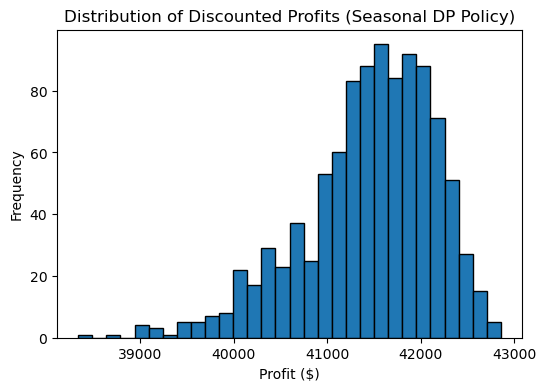

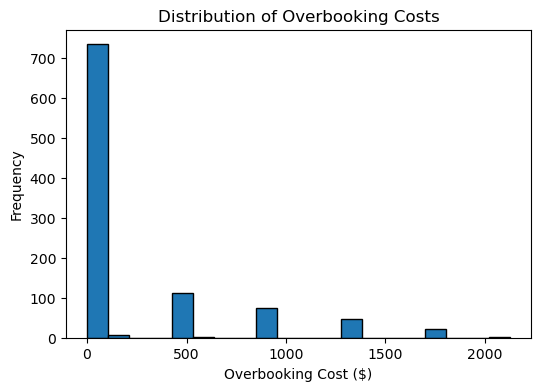

In [3]:
np.random.seed(42)

T = 365

coach_capacity  = 100
fc_capacity = 20
overbook_extra = 5 # Allow 5 extra seats beyond 100
max_coach_sold = coach_capacity + overbook_extra  # e.g., 105
fc_max_sold = fc_capacity # 20

annual_rate = 0.17
delta = 1.0 / (1 + annual_rate / 365)

cost_bump_up = 50
cost_bump_off = 425
prob_show_coach = 0.95
prob_show_fc = 0.97

def coach_prob_seasonal(price_coach, fc_sold_out, coach_full, t):
    if coach_full:
        return 0.0
    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30
    
    # If first-class sold out, +3% to base
    if fc_sold_out:
        base_p += 0.03
    
    # Seasonality factor
    season_factor = 0.75 + t/730.0
    # Multiply 
    p = base_p * season_factor
    return min(p, 1.0)

def fc_prob_seasonal(price_fc, coach_full, fc_sold, t):
    if coach_full:
        return 0.0
    if fc_sold >= fc_capacity:
        return 0.0
    if price_fc == 425:
        base_p = 0.08
    else:
        base_p = 0.04
    
    # Seasonality factor
    season_factor = 0.75 + t/730.0
    p = base_p * season_factor
    return min(p, 1.0)

# 4 price combos
coach_prices = [300, 300, 350, 350]
fc_prices = [425, 500, 425, 500]

def expected_overbook_cost(x_coach, x_fc):
    cost = 0.0
    for c in range(x_coach+1):
        pc = stats.binom.pmf(c, x_coach, prob_show_coach)
        for f in range(x_fc+1):
            pf = stats.binom.pmf(f, x_fc, prob_show_fc)
            p_joint = pc * pf
            
            leftover_fc = max(0, fc_capacity - f)
            if c <= coach_capacity:
                bump_to_fc = 0
                bump_off = 0
            else:
                to_bump = c - coach_capacity
                bump_to_fc = min(leftover_fc, to_bump)
                bump_off = to_bump - bump_to_fc
            
            scenario_cost = cost_bump_up*bump_to_fc + cost_bump_off*bump_off
            cost += p_joint * scenario_cost
    return cost

# State: (coach_sold, fc_sold, t) with t in [0..365]
V = np.zeros((max_coach_sold+1, fc_max_sold+1, T+1))
U = np.zeros((max_coach_sold+1, fc_max_sold+1, T+1))

# Fill terminal condition at day T
for x_c in range(max_coach_sold+1):
    for x_f in range(fc_max_sold+1):
        cost_terminal = expected_overbook_cost(x_c, x_f)
        V[x_c, x_f, T] = -cost_terminal
        U[x_c, x_f, T] = 0  # no sales at departure

# For t in [T-1 .. 0], incorporate the factor (0.75 + t/730) each day.
for tday in reversed(range(T)):
    for x_c in range(max_coach_sold+1):
        for x_f in range(fc_max_sold+1):
            best_val = -1e15
            best_act = 0
            fc_sold_out = (x_f >= fc_max_sold)
            coach_full  = (x_c >= max_coach_sold)
            
            # Try each of the 4 price combos
            for action_idx in range(4):
                pc = coach_prices[action_idx]
                fc = fc_prices[action_idx]
                
                # seasonal daily probabilities:
                p_c = coach_prob_seasonal(pc, fc_sold_out, coach_full, tday)
                p_f = fc_prob_seasonal(fc, coach_full, x_f, tday)
                
                # 4 outcome probabilities
                p00 = (1 - p_c)*(1 - p_f)
                p10 = p_c*(1 - p_f)
                p01 = (1 - p_c)*p_f
                p11 = p_c*p_f
                
                # immediate revenue
                immediate_rev = (p10*pc + p01*fc + p11*(pc+fc))
                
                # next state
                vc00 = V[x_c,   x_f,   tday+1]
                vc10 = V[min(x_c+1, max_coach_sold), x_f,   tday+1]
                vc01 = V[x_c,   min(x_f+1, fc_max_sold), tday+1]
                vc11 = V[min(x_c+1, max_coach_sold), min(x_f+1, fc_max_sold), tday+1]
                
                exp_val_next = p00*vc00 + p10*vc10 + p01*vc01 + p11*vc11
                total_val = immediate_rev + delta * exp_val_next
                
                if total_val > best_val:
                    best_val = total_val
                    best_act = action_idx
            
            V[x_c, x_f, tday] = best_val
            U[x_c, x_f, tday] = best_act

N = 1000
profits = np.zeros(N)

# Track how many times coach is 'overbooked' at show-up (meaning c_show>100)
# how often passengers get bumped off, and total bumping cost as well.
overbook_count = 0  # how many sims had c_show>100
bump_off_count = 0  # how many sims had bump_off>0
bump_costs = np.zeros(N)

for sim in range(N):
    c_sold = 0
    f_sold = 0
    sim_revenue = 0.0
    
    for day in range(T):
        action_idx = int(U[c_sold, f_sold, day])
        pc = coach_prices[action_idx]
        fc = fc_prices[action_idx]
        
        # compute seasonal daily probability
        fc_sold_out = (f_sold >= fc_max_sold)
        coach_full = (c_sold >= max_coach_sold)
        
        p_c = coach_prob_seasonal(pc, fc_sold_out, coach_full, day)
        p_f = fc_prob_seasonal(fc, coach_full, f_sold, day)
        
        # realize 0/1 sale in coach, 0/1 in FC
        c_sale = (np.random.rand() < p_c)
        f_sale = (np.random.rand() < p_f)
        
        daily_rev = 0.0
        if c_sale:
            daily_rev += pc
            c_sold += 1
        if f_sale:
            daily_rev += fc
            f_sold += 1
        
        # discount daily revenue
        sim_revenue += daily_rev * (delta**day)
    
    # departure day: actual show-ups
    c_show = np.random.binomial(c_sold, prob_show_coach)
    f_show = np.random.binomial(f_sold, prob_show_fc)
    
    leftover_fc = max(0, fc_capacity - f_show)
    if c_show <= coach_capacity:
        bump_off_amt = 0
        bump_to_fc_amt = 0
    else:
        to_bump = c_show - coach_capacity
        bump_to_fc_amt = min(leftover_fc, to_bump)
        bump_off_amt = to_bump - bump_to_fc_amt
    
    over_cost = cost_bump_up * bump_to_fc_amt + cost_bump_off * bump_off_amt
    sim_revenue -= over_cost * (delta**T)
    profits[sim] = sim_revenue
    
    # record stats
    if c_show > coach_capacity:
        overbook_count += 1
    if bump_off_amt > 0:
        bump_off_count += 1
    bump_costs[sim] = over_cost

mean_profit = profits.mean()
std_profit = profits.std()
overbook_pct = overbook_count / N * 100
bump_off_pct = bump_off_count / N * 100
mean_bump = bump_costs.mean()
max_profit = profits.max()
print(f"Highest Profit: ${max_profit:,.2f}")

print(f"===== FORWARD SIMULATION RESULTS (With Seasonality) =====")
print(f"Mean Profit: ${mean_profit:,.2f}")
print(f"Std Dev of Profit: ${std_profit:,.2f}")
print(f"Coach Overbook Frequency: {overbook_pct:0.1f}%")
print(f"Bump-Off Frequency: {bump_off_pct:0.1f}%")
print(f"Avg Overbooking Cost: ${mean_bump:0.2f}")

plt.figure(figsize=(6,4))
plt.hist(profits, bins=30, edgecolor='k')
plt.title("Distribution of Discounted Profits (Seasonal DP Policy)")
plt.xlabel("Profit ($)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(bump_costs, bins=20, edgecolor='k')
plt.title("Distribution of Overbooking Costs")
plt.xlabel("Overbooking Cost ($)")
plt.ylabel("Frequency")
plt.show()